<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork820-2023-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# ***Tackle Imbalanced Data Challenge (Abordar el desafío de datos desequilibrados)***

$ \ $

In this lab, you will identify the imbalanced data problems in four binary classification scenarios, all with skewed class distributions:

| Task Name     | Class Ratio (Negative vs. Positive)  |
| ------------- |:-------------:|
| _Credit Card Fraud Detection_      | ~1000 : 1      | 
| _Predicting Customer Churn_ | ~5 : 1      | 
| _Tumor Type Estimation_ | ~2 : 1     | 
| _Predicting Job Change_ | ~10 : 1      | 


Next, you will try to tackle the imbalanced data challenges in the above tasks using class weighting and resampling methods:


* Effective class weighting strategies will assign minority class with more weights, so that it may have a larger impact on the model training process.

* Resampling methods will generate synthetic datasets from the original datasets.


$ \ $

----

## ***Objectives***

After completing this lab you will be able to:

* Identify typical patterns of imbalanced data challenges.

* Apply `Class Re-weighting` method to adjust the impacts of different classes in model training processes.

* Apply `Oversampling` and `Undersampling` to generate synthetic datasets and rebalance classes.

* Evaluate your consolidated classifiers using robust metrics such as `F-score` and `AUC.`


$ \ $

-----

## ***Load the necessary packages***

$ \ $

Let's import the required packages for this lab.

In [ ]:
!pip install imbalanced-learn==0.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import imblearn
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [ ]:
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning) 
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning) 
warnings.filterwarnings("ignore", category = FutureWarning) 

In [ ]:
def zip(list_1, list_2):
  lista = []
  if len(list_1) == len(list_2):
    for i in range(len(list_1)):
      lista.append((list_1[i], list_2[i]))
  return lista

$ \ $

-----

## ***Grid search methods***

$ \ $

$(1)$ We want to provide some sample grid search functions if you are interested in tuning your model.

In [ ]:
# red de busqueda de hiperparametros para un modelo de regresion logistica
def grid_search_lr(X_train, y_train):

    # creamos un diccionario donde describimos los parametros de de la red de busqueda GridSearchCV que crearemos mas adelante
    params_grid = {'class_weight': [{0 : 0.05, 1 : 0.95}, {0 : 0.1, 1 : 0.9}, {0 : 0.2, 1 : 0.8}]}

    # creamos un modelo de regresion logistica
    lr_model = LogisticRegression(random_state = 123, max_iter = 1000)

    # creamos una red de busqueda tomando como estimador el modelo de regresion logistica y como parametros de red los creados previamente
    grid_search = GridSearchCV(estimator = lr_model, 
                               param_grid = params_grid, 
                               scoring = 'f1',
                               cv = 5,
                               verbose = 1)
    
    # entrenamos nuestra red de busqueda con la data de entrenamiento X_train, y_train
    grid_search.fit(X_train, y_train)

    # describimos los mejores parametros de nuestra red de busqueda entrenada
    best_params = grid_search.best_params_

    # la funcion devuelve los mejores parametros
    return best_params
    

In [ ]:
# hiperparámetros de búsqueda en la red para un modelo de bosque aleatorio
def grid_search_rf(X_train, y_train):

    # describimos los parametros de la red
    params_grid = {'class_weight': [{0 : 0.1, 1 : 0.9}, {0 : 0.2, 1 : 0.8}, {0 : 0.3, 1 : 0.7}],
                   'max_depth': [5, 10, 15, 20],
                   'n_estimators': [25, 50, 100],
                   'min_samples_split': [2, 5]}

    # creamos un bosque clasificador aleatorio
    rf_model = RandomForestClassifier(random_state = 123)

    # creamos una red de busqueda teniendo en cuenta como estimador el bosque clasificador aleatorio y los parametros construidos anteriormente
    grid_search = GridSearchCV(estimator = rf_model,
                               param_grid = params_grid,
                               scoring = 'f1',
                               cv = 5,
                               verbose = 1)

    # entrenamos la red de busqueda con la data de entramiento X_train, y_train
    grid_search.fit(X_train, y_train)

    # describimos los mejores parametros de la red de busqueda
    best_params = grid_search.best_params_

    # la funcion devuelve los mejores parametros
    return best_params
    

$ \ $

$(2)$ We define a function that split the training and testing dataset.

In [ ]:
# tomamos un dataframe y lo separamos en la data de prueba y la data de entrenamiento
def split_data(df):

    # describimos los datos predectivos
    X = df.loc[ : , df.columns != 'Class']

    # describimos la data objetivo 
    y = df['Class'].astype('int') 

    # la funcion describe la data de prueba y la data de entrenamiento
    return train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123) 

$ \ $

-----

## ***Scenario: Credit Card Fraud Detection***

$ \ $

Let's start with a credit card fraud detection scenario. The dataset contains transactions made by credit cards. As you can imagine, the majority of transactions are normal and only a very few real fraud transactions are in the dataset. Our goal is to train a classification model to recognize those fraudulent credit card transactions.

$ \ $

$(1)$ We load the dataset as a dataframe.

In [ ]:
credit_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_credit.csv", index_col=False)

In [ ]:
credit_df.head()

,V14,V17,V4,V10,V28,Class
0,0.423619,-0.210863,0.933459,0.027866,0.019308,0
1,0.986727,0.174009,-2.019905,-1.620065,-0.307753,0
2,-0.023094,-0.541985,-0.902618,-0.192212,-0.048965,0
3,-0.152111,-0.615094,1.276126,-0.026822,0.044480,0
4,-0.535807,-0.248563,4.517539,1.871441,0.120955,0


Due to confidentiality issues, the original features and other background information about each transaction is hidden, and this dataset now contains only numerical features which are the result of a PCA transformation.

$ \ $

$(2)$ Let's see how imbalanced this dataset is.

In [ ]:
valores = credit_df['Class'].value_counts()
valores

0    200000
1       200
Name: Class, dtype: int64

<Axes: >

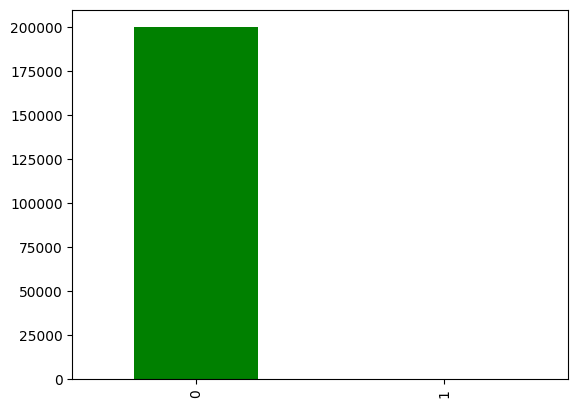

In [ ]:
valores.plot.bar(color = ["green", "red"])

As you can see, we only have about $0.001$% fraud transactions in the dataset and you can not even see it on the previous bar chart! This is an extremely imbalanced dataset.

$ \ $

$(3)$ We will quickly build a logistic regression model to see how it performs on such an imbalanced dataset.


In [ ]:
X_train, X_test, y_train, y_test = split_data(credit_df)

In [ ]:
# creamos un modelo de regresion logistica
model = LogisticRegression(random_state = 123, max_iter = 1000)

# entrenamos el modelo de regresion logistica  con la data de entrenamiento X_train, y_train
model.fit(X_train, y_train)

# predecimos un conjunto de datos con nuestro modelo entrenado y la data de prueba X_test
y_pred = model.predict(X_test)

$ \ $

$(4)$ We check the prediction accuracy.

In [ ]:
accuracy_score(y_test, y_pred)

0.9992757242757243

OK, it achieves $99$% prediction accuracy on the test dataset, looks like a great model! Before concluding we have  found a simple and great model to detect credit card frauds, let's try other metrics first.

$ \ $

----

## ***More Robust Evaluation Metrics***

$ \ $

Here are some effective robust binary classification evaluation metrics such as:

* Accuracy, 

* Precision, 

* Recall,

* Fscore,

which can be defined as follows:

$ \ $

* $\text{Accuracy} = \dfrac{TP+TN}{TP+TN+FP+FN}$.

$ \ $

* $\text{Precision} = \dfrac{TP}{TP+FP}$.

$ \ $

* $\text{Recall} = \dfrac{TP}{TP+FN}$.

$ \ $

* $\text{Fscore} = \dfrac{\text{Precision}\cdot \text{Recall} }{\frac{\text{Precision}+\text{Recall}}{2}}$.


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/images/evaluation_metrics.png" width="720" alt="evaluation metrics">
</center>


$ \ $

Let's calculate Precision, Recall, and Fscore.

In [ ]:
# describimos el puntaje accuracy con la data de prueba y la data predecida y_test, y_pred
accuracy = accuracy_score(y_test, y_pred)

# describimos precision, recall, fbeta
precision, recall, fbeta, support = precision_recall_fscore_support(y_test, y_pred, beta = 5, pos_label = 1, average = 'binary')

# describimos el puntaje roc
auc = roc_auc_score(y_test, y_pred)

In [ ]:
print(f"Accuracy = {accuracy:.2f}")
print(f"Precision = {precision:.2f}")
print(f"Recall = {recall:.2f}")
print(f"Fscore = {fbeta:.2f}")
print(f"AUC = {auc:.2f}")

Accuracy = 1.00
Precision = 0.72
Recall = 0.45
Fscore = 0.46
AUC = 0.72


For many machine learning tasks on imbalanced datasets, like this credit card fraud detection, we normally care more about recall than precision. As a baseline, we want the model to be able to find all frauds and we would allow the model to make $\color{yellow}{\text{false-positive}}$ errors because the cost of $\color{yellow}{\text{false-positive}}$ is usually not very high (maybe just costs a false notification email or phone call to confirm with customers). On the other hand, failing to recognize positive examples (such as fraud or a deadly disease) can be life-threatening (peligroso para la vida). As such, our priority is to improve the model's recall, then we will also want to keep precision as high as possible.

$ \ $

-----

## ***Synthetic Minority Oversampling Technique (SMOTE)***

## ***Técnica de sobremuestreo de minorías sintéticas***

$ \ $

A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model. An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. This is a type of data augmentation for tabular data and can be very effective. Perhaps the most widely used approach to synthesizing new examples is called the $\color{lightblue}{\text{Synthetic Minority Oversampling TEchnique}}$, or $\color{aquamarine}{\text{SMOTE}}$ for short. 

$ \ $

$\color{aquamarine}{\text{SMOTE}}$ works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then $k$ of the nearest neighbors for that example are found (typically $k=5$). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space. 

$ \ $

It suggests first using random undersampling to trim (recortar) the number of examples in the majority class, then use $\color{aquamarine}{\text{SMOTE}}$ to oversample the minority class to balance the class distribution. The combination of $\color{aquamarine}{\text{SMOTE}}$ and under-sampling performs better than plain under-sampling. The approach is effective because new synthetic examples from the minority class are created that are plausible, that is, are relatively close in feature space to existing examples from the minority class.

$ \ $

$(1)$ Let's use its $\color{aquamarine}{\text{SMOTE}}$ class to define a $\color{aquamarine}{\text{SMOTE}}$ sampler first


In [ ]:
smote_sampler = SMOTE(random_state = 123)

$ \ $

$(2)$ We resample the training data using $\color{aquamarine}{\text{SMOTE}}$.

In [ ]:
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

$ \ $

$(3)$ After $\color{aquamarine}{\text{SMOTE}}$ resampling, we can see both positive and negative class has the same instances.

In [ ]:
y_vals = y_smo.value_counts()
y_vals

0    160000
1    160000
Name: Class, dtype: int64

<Axes: >

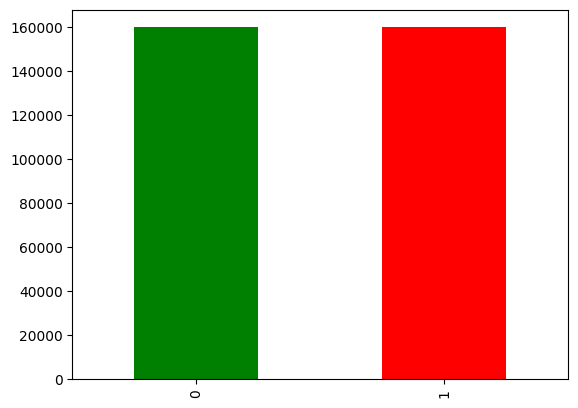

In [ ]:
y_vals.plot.bar(color = ['green', 'red'])

$ \ $

$(4)$ Let's retrain the logistic regression model with resampled training data using $\color{aquamarine}{\text{SMOTE}}$.

In [ ]:
# entrenamos el modelo con la muestra de SMOTE ---> X_smo, y_smo
# model = LogisticRegression(random_state = 123, max_iter = 1000)
model.fit(X_smo, y_smo)

# predecimos un conjunto de datos con nuestro modelo entrenado y la data de prueba
y_pred = model.predict(X_test)

$ \ $

$(5)$ We re-evaluate the model to see if there are any improvements with respect to:

* Accuracy,

* Precision,

* Recall,

* F1,

* AUC.

In [ ]:
# describimos precision, recall, fbeta teniendo en cuenta la data de prueba y la data predecida previamente
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, y_pred, beta = 5, pos_label = 1, average = 'binary')

# calculamos el puntaje AUC entre la data de prueba y la data predecida
auc = roc_auc_score(y_test, y_pred)

# calculamos el puntaje accuracy
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 0.97
Precision is: 0.03
Recall is: 0.88
Fscore is: 0.42
AUC is: 0.92


Taking into a count the previous results, we can said the following things:

$ \ $

$(\checkmark)$ We can see AUC is improved from $0.72$ to $0.92$, this is a good sign as SMOTE improves model classification ability.

$ \ $

$(\checkmark)$ The recall is now $0.88$, mostly two times larger than the original recall value of $0.45$.

$ \ $

$(\checkmark)$ However, our model's precision is only $0.03$. One possible reason is our dataset was extremely skewed, and oversampling the minority class significantly disrupts the original data distribution so that the model trained on the SMOTE dataset generates large false positives on the test dataset sampled from the original dataset.

$ \ $

$(\checkmark)$ As such, for an extremely skewed dataset, we generally do not use oversampling as it significantly shifts the original data distribution.

$ \ $

-----

## ***Class reweighting (reajuste de clase - Reponderación de clase)***

$ \ $

For $\color{yellow}{\text{binary classification models}}$, its loss function is normally calculated via a sum of the loss with respect to class $0$ and the loss with respect to class $1$. By default, their class weights are all $1$'s meaning we treat each class equally important.  However, since the class distribution is skewed in imbalanced datasets and the loss function optimization process will be dominated by the majority class, we want to help the minority class by increasing its class weight in the loss function. Class weights can be generally calculated via the following three strategies:

$ \ $

$(1)$ Based on their instances portion in the dataset. 

For example, if positive instances only take $10$% of the dataset, we assign its weight to be $0.9$ and the weight for the majority class to be $0.1$.

$ \ $

$(2)$ Heuristics or domain knowledge. 

Misclassification normally has different costs per class, for example, the cost of failure to diagnose a disease is much higher than a false positive diagnose. If we already know such misclassification costs beforehand, we may use them to assign class weights.

$ \ $

$(3)$ Hyper-parameter tuning. 


Standard hyper-parameter tuning methods can be used to find optimized class weights. For example, grid searching from $0.1$ to $0.9$ for positive class weight to find out which hyperparameter combination generates the best model.

$ \ $

***Python sklearn package*** provides a very convenient way to adjust class weights during model training via providing a class weight argument. Many standard classifiers in sklearn such as:

* `LogisticRegression` 

* `RandomForestClassifier`

support class reweighting natively. 

$ \ $

$(1)$ We create a class weights dictionary.

In [ ]:
class_weight = {0 : 0.1, 1 : 0.9}

$ \ $

$(2)$ Let's use the class weight dictionary in a ***LogisticRegression model*** by specifying it as the `class_weight` argument.


In [ ]:
# definimos un modelo de regresion logistica con los parametros mostrados
model = LogisticRegression(random_state = 123, max_iter = 1000, class_weight = class_weight)

$ \ $

$(3)$ Let's train and predict some values using our previous model.

In [ ]:
# entrenamos nuestro modelo 
model.fit(X_train, y_train)

# predecimos un conjunto de datos con nuestro modelo
y_pred = model.predict(X_test)

During the training process, the positive instance will have much larger influence on reducing the total loss and weight updates. The trained classifier will be enhanced to recognize positive instances (increase recall).

$ \ $

$(4)$  Let's see if our metrics are getting better.

In [ ]:
# describimos las metricas precision, recall, f_beta usando la data de prueba y la data predecida y_test, y_pred
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, y_pred, beta = 5, pos_label = 1, average = 'binary')

# calculamos el puntaje AUC
auc = roc_auc_score(y_test, y_pred)

# calculamos el puntaje de accuracy
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 1.00
Precision is: 0.65
Recall is: 0.82
Fscore is: 0.82
AUC is: 0.91


As you can see, we have much balanced `Precision` and `Recall` values. It indicates that, for an extremely imbalanced dataset like credit card fraud detection, often: 

$ \ $

$$\color{orange}{\text{class reweighting is a better strategy than oversampling.}}$$

$$\color{orange}{\text{reajuste de clase es una mejor estrategia que el sobremuestreo.}}$$

$ \ $ 

Since undersampling will significantly shrink the training dataset, we normally do not use undersampling for an extremely imbalanced dataset. 
To summarize the findings from the credit card fraud detection task:


* All models have very high accuracy and AUC values but this does not always mean they have good prediction performance, especially for classifying the fraud cases.


* Classification on an extremely imbalanced dataset is usually a hard task, especially if we want to have both high recall and precision values.


* `SMOTE` can achieve high recall but extremely low precision due to the caused disruptions of original data distribution.


* Class reweighting can achieve a more balanced recall and precision value than oversampling.



$ \ $

----

## ***Some utility model training and evaluation methods***

$ \ $

Before we continue with more imbalanced classification scenarios, let's define some utility functions for you to simplify this lab and increase notebook readability. 

$ \ $

$(1)$ The following function builds and trains a logistic regression model.

In [ ]:
# construimos una funcion la cual devuelve un modelo de regresion logistica
def build_lr(X_train, y_train, X_test, threshold = 0.5, best_params = None):
    
    # construimos un modelo de regresion logistica con un maximo de iteraciones de 1000
    model = LogisticRegression(random_state = 123, max_iter = 1000)

    # si nos dan parametros, entonces realizamos este condicional
    if best_params:

        # actualizamos el modelo de regresion logistica con ajuste de clase igual a best_params['class_weight']
        model = LogisticRegression(penalty = 'l2', random_state = 123, max_iter = 1000, class_weight = best_params['class_weight'])   
   
    # entrenamos nuestro modelo de regresion logistica con la data de entrenamiento X_train, y_train
    model.fit(X_train, y_train)

    # predecimos la probabilidad del modelo usando la data de prueba X_test
    predicted_proba = model.predict_proba(X_test)

    # Si la probabilidad pronosticada es mayor que el umbral (el valor predeterminado es 0,5), genere una etiqueta positiva
    y_pred = (predicted_proba[:, 1] >= threshold).astype('int')

    # la funcion devuelve el modelo de regresion logistica y los datos que son mayores al umbral
    return y_pred, model

$ \ $

$(2)$ The following function builds and trains a random forest.

In [ ]:
# construimos una funcion la cual devuelve un clasificador de bosques aleatorio entrenado
def build_rf(X_train, y_train, X_test, threshold = 0.5, best_params = None):
    
    # creamos un clasificador de bosques aleatorio
    model = RandomForestClassifier(random_state = 123)

    # si algunos parametros son establecidos, entonces ejecutamos este condicional
    if best_params:

        # creamos un clasificador de bosques aleatorio con los parametros establecidos
        model = RandomForestClassifier(# establecemos como el estado aleatorio igual a 123
                                       random_state = 123,

                                       # Si se utilizamos muestreo de arranque
                                       bootstrap = best_params['bootstrap'],
                                       
                                       # describimos la profundidad maxima de cada arbol
                                       max_depth = best_params['max_depth'],
                                       
                                       # describimos los parametros de peso de la clase
                                       class_weight = best_params['class_weight'],
                                       
                                       # describimos el numero de arboles
                                       n_estimators = best_params['n_estimators'],
                                       
                                       # establecemos la minima cantidad de muestras a separar
                                       min_samples_split = best_params['min_samples_split'])
        

    # entrenamos el modelo  
    model.fit(X_train, y_train)

    # establecemos la probabilidad del modelo usando la data de prueba X_test
    predicted_proba = model.predict_proba(X_test)

    # Si la probabilidad pronosticada es mayor que el umbral, entonces generamos una etiqueta positiva
    y_pred = (predicted_proba [:,1] >= threshold).astype('int')

    # la funcion devuelve el clasificador de bosques aleatorio entrenado junto con y_pred
    return y_pred, model

$ \ $

$(3)$ The following function evaluates a classifier's predictions.

In [ ]:
# Esta funcion toma data de prueba y data predecida y arroja como resultado un diccionario que describe las metricas basicas
def evaluate(y_test, y_pred, eval_type = "Original"):

    # creamos un diccionario vacio
    results_pos = {}

    # creamos un elemento para el diccionario ----> 'type': eval_type
    results_pos['type'] = eval_type

    # creamos un elemento para el diccionario ----> 'accuracy': accuracy_score(y_test, y_pred)
    results_pos['accuracy'] = accuracy_score(y_test, y_pred)

    # establecemos Precision, recall, Fscore
    precision, recall, f_beta, support = precision_recall_fscore_support(y_test, y_pred, beta = 5, pos_label = 1, average = 'binary')

    # creamos un elemento para el diccionario ----> 'recall': recall
    results_pos['recall'] = recall

    # creamos un elemento para el diccionario ----> 'auc': roc_auc_score(y_test, y_pred)
    results_pos['auc'] = roc_auc_score(y_test, y_pred)

    # creamos un elemento para el diccionario ----> 'precision': precision
    results_pos['precision'] = precision

    # creamos un elemento para el diccionario ----> 'fscore': f_beta
    results_pos['fscore'] = f_beta

    # la funcion devuelve el diccionario creado anteriormente
    return results_pos

$ \ $

$(4)$ The following function resamples the original dataset.

In [ ]:
# volvemos a muestrear X_train, y_train
def resample(X_train, y_train):

    # creamos un modelo de sobremuestreo de minorías sintéticas (SMOTE)
    smote_sampler = SMOTE(random_state = 123)

    # creamos un submuestrador aleatorio
    under_sampler = RandomUnderSampler(random_state = 123)

    # fit_resample vuelve a muestrear los datos (X) y objetivos (y) en un diccionario
    # con un par (clave,valor) <----> (data_resampled, targets_resampled) = (X_smo, y_smo)
    X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

    # fit_resample vuelve a muestrear los datos (X) y objetivos (y) en un diccionario
    # con un par (clave,valor) <----> (data_resampled, targets_resampled) = (X_smo, y_smo)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train)

    # la funcion devuelve los datos remuestrados
    return X_smo, y_smo, X_under, y_under

$ \ $

$(5)$ The following function visualizes the metrics.

In [ ]:
# visualizamos el diccionario results el cual nos dice informacion sobre las metricas clasicas
def visualize_eval_metrics(results):

    # creamos un dataframe con el diccionario results
    df = pd.DataFrame(data = results)

    # mostramos el dataframe df
    print(df)
    print("\n")

    # creamos el array dado por array([0, 1, 2, 3, 4])
    x = np.arange(5)

    # tomamos todos los elementos del renglon 0, excepto el primero
    original = df.iloc[0, 1:].values

    # tomamos todos los elementos del renglon 1, excepto el primero
    class_weight = df.iloc[1, 1:].values

    # tomamos todos los elementos del renglon 2, excepto el primero
    smote = df.iloc[2, 1:].values

    # tomamos todos los elementos del renglon 3, excepto el primero
    under = df.iloc[3, 1:].values

    # establecemos el ancho igual a 0.2
    width = 0.2

    # creamos una imagen  de tamaño 12x10
    figure(figsize = (12, 10), dpi = 80)

    # realizamos un plot    
    # x-0.2 = array([-0.2, 0.8, 1.8, 2.8, 3.8]) <------- el eje x
    # la data original <-------el eje y
    plt.bar(x-0.2, original, width, color = '#95a5a6')

    # realizamos un plot    
    # array([0, 1, 2, 3, 4]) <------- el eje x
    # class_weight <-------el eje y
    plt.bar(x, class_weight, width, color = '#d35400')

    # realizamos un plot    
    # x+0.2 = array([0.2, 1.2, 2.2, 3.2, 4.2]) <------- el eje x
    # smote <-------el eje y
    plt.bar(x+0.2, smote, width, color = '#2980b9')

    # realizamos un plot    
    # x+0.4 = array([0.4, 1.4, 2.4, 3.4, 4.4]) <------- el eje x
    # width <-------el eje y
    plt.bar(x+0.4, under, width, color = '#3498db')

    # establecemos los valores del eje x
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])

    # realizamos el titulo del eje x
    plt.xlabel("Evaluation Metrics")

    # realizamos el titulo del eje y
    plt.ylabel("Score")

    # describimos la leyenda de la imagen
    plt.legend(["Original", "Class Weight", "SMOTE", "Undersampling"])

    # la funcion devuelve la imagen creada anteriormente
    return plt.show()

$ \ $

------

## ***Scenario: Predicting Customer Churn***

$ \ $

We will be predicting customer churns (leaving the business) of a telecom company.

$ \ $

$(1)$ Let's read the dataset.

In [ ]:
churn_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_churn.csv", index_col = False)
churn_df.head()

,tenure,MonthlyCharges,TotalCharges,Partner_0,Partner_1,Dependents_0,Dependents_1,PhoneService_0,PhoneService_1,MultipleLines_0,...,Contract_0,Contract_1,Contract_2,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,Class
0,27,70.55,1943.90,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
1,69,93.30,6398.05,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,55,59.20,3175.85,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
3,49,59.60,2970.30,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,72,109.55,7887.25,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0


This dataset is processed and contains features about a customer's telcom service types, tenure, charges, and payments. Based on such features, we would like to predict if a customer is leaving the business or not (churn).

$ \ $

$(2)$ We split the data into training and testing datasets.

In [ ]:
X_train, X_test, y_train, y_test = split_data(churn_df)

$ \ $

$(3)$ We take a look at its class distribution.

In [ ]:
valores = y_train.value_counts()
valores

0    4139
1     800
Name: Class, dtype: int64

<Axes: >

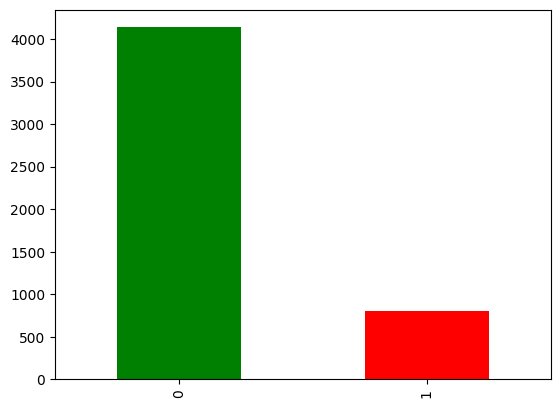

In [ ]:
valores.plot.bar(color = ['green', 'red'])

As we can see from the bar chart above, the non-churn customers are almost 4 times more than the churn customers, which makes it an imbalanced dataset as well. Since this dataset has 42 features, it would be better to use a more complex classification model and we choose to use `RandomForestClassifier` from `sklearn` package.

$ \ $

$(4)$  Tuned random forest parameters.

In [ ]:
best_params_no_weight = {'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}

$ \ $

$(5)$ Train a regular random forest classifier.

In [ ]:
# creamos una lista vacia
results = []

# construimos un clasificador de bosques aleatorio entrenado
y_pred, model = build_rf(X_train, y_train, X_test, best_params = best_params_no_weight)

# describimos con la funcion evaluate un diccionario que describe las metricas basicas respecto a la data de prueba y la data de entrenamiento
result = evaluate(y_test, y_pred, "Original")

# pegamos el diccionario en la lista
results.append(result)

# mostramos el diccionario en pantalla
result

{'type': 'Original',
 'accuracy': 0.8623481781376519,
 'recall': 0.28,
 'auc': 0.6274396135265701,
 'precision': 0.6829268292682927,
 'fscore': 0.2865013774104683}

As you may expect, we have a very high prediction `accuracy` but even using a random forest classifier, our `recall` is very low with only 0.28. 

$ \ $

---

## ***Add class re-weighting***

$ \ $

$(1)$ We add class weights to the random forest classifier with pre-tuned:

* weight of $0.8$ to churn class.

* weight $0.2$ to non-churn class.

In [ ]:
# 0.2 to Non-churn class
# 0.8 to Churn class
class_weight = {0: 0.2, 1: 0.8}

$ \ $

$(2)$ We create the pre-tuned hyper parameters.

In [ ]:
best_params_weight = {'class_weight': class_weight,
                      'max_depth': 10,
                      'min_samples_split': 5,
                      'n_estimators': 50,
                      'bootstrap': True}

$ \ $

$(3)$ Build a random forest model with the class weight $0.8$ vs. $0.2$.

In [ ]:
# usamos la funcion creada anteriormente para crear un modelo de bosques aleatorio
y_pred, weight_model = build_rf(X_train, y_train, X_test, best_params = best_params_weight)

$ \ $

$(4)$ Evaluate the refined model.

In [ ]:
#  creamos un diccionario que describe las metricas basicas de la data de prueba y la data predecida y_test, y_pred
result = evaluate(y_test, y_pred, "Class Weight")

# pegamos este diccionario en la lista anterior
results.append(result)

# mostramos el diccionario en pantalla
result

{'type': 'Class Weight',
 'accuracy': 0.8137651821862348,
 'recall': 0.62,
 'auc': 0.7356038647342995,
 'precision': 0.4460431654676259,
 'fscore': 0.6108374384236454}

As we can see from the evaluation results above, `Recall` and `Fscore` are significantly improved by adding class weights. Such improvements indicate that class reweighting is effective for the imbalanced customer churn dataset.


$ \ $

-----

## ***Resampling: SMOTE and Undersampling***

$ \ $

$(1)$ We use the ***resample function*** to see if it is also able to improve the model performance.

In [ ]:
# X_smo se vuelve a muestrear desde X_train usando SMOTE
# y_smo se vuelve a muestrear desde y_train usando SMOTE

# X_under se vuelve a muestrear desde X_train usando Undersampling
# y_under se vuelve a muestrear desde y_train usando Undersampling

# volvemos a muestrear X_train, y_train
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

$ \ $

$(2)$ We can retrain a random forest classifier using ***SMOTE*** resampled input `X_smo` and output `y_smo` and evaluate its performance.


In [ ]:
# creamos un modelo de bosques aleatorio
y_pred, smo_model = build_rf(X_smo, y_smo, X_test, best_params = best_params_no_weight)

# creamos un diccionario que describe las metricas basicas de la data de prueba y la data predecida y_test, y_pred
result = evaluate(y_test, y_pred, "SMOTE")

# pegamos el resultado anterior a la lista results
results.append(result)

# mostramos el diccionario creado anteriormente
result

{'type': 'SMOTE',
 'accuracy': 0.8331983805668016,
 'recall': 0.505,
 'auc': 0.7008091787439613,
 'precision': 0.4855769230769231,
 'fscore': 0.5042242703533026}

$ \ $ 

$(3)$ We retrain a random forest classifier using the undersampled input `X_under` and output `y_under` and evaluate its performance.


In [ ]:
# construimos una funcion la cual devuelve un modelo de regresion logistica
preds_under, under_model = build_rf(X_under, y_under, X_test, best_params = best_params_no_weight)

# creamos un diccionario que describe las metricas basicas de la data de prueba y la data predecida y_test, y_pred
result = evaluate(y_test, preds_under, "Undersampling")

# pegamos el diccionario creado anteriormente en la lista results
results.append(result)

# mostramos el diccionario
result

{'type': 'Undersampling',
 'accuracy': 0.7336032388663968,
 'recall': 0.79,
 'auc': 0.7563526570048309,
 'precision': 0.3550561797752809,
 'fscore': 0.7544536271809001}

$ \ $

----

## ***Compare the performance among different random forest models***

$ \ $

$(1)$ By now, we have built four different random forest models:

* the model trained with the original dataset, 

* the model with class weights,

* the model trained with SMOTE dataset,

* the model trained with undersampling.

To better analyze and compare their performance, we can visualize the metrics using a grouped bar chart.

In [ ]:
print(results)

[{'type': 'Original', 'accuracy': 0.8623481781376519, 'recall': 0.28, 'auc': 0.6274396135265701, 'precision': 0.6829268292682927, 'fscore': 0.2865013774104683}, {'type': 'Class Weight', 'accuracy': 0.8137651821862348, 'recall': 0.62, 'auc': 0.7356038647342995, 'precision': 0.4460431654676259, 'fscore': 0.6108374384236454}, {'type': 'SMOTE', 'accuracy': 0.8331983805668016, 'recall': 0.505, 'auc': 0.7008091787439613, 'precision': 0.4855769230769231, 'fscore': 0.5042242703533026}, {'type': 'Undersampling', 'accuracy': 0.7336032388663968, 'recall': 0.79, 'auc': 0.7563526570048309, 'precision': 0.3550561797752809, 'fscore': 0.7544536271809001}]


            type  accuracy  recall       auc  precision    fscore
0       Original  0.862348   0.280  0.627440   0.682927  0.286501
1   Class Weight  0.813765   0.620  0.735604   0.446043  0.610837
2          SMOTE  0.833198   0.505  0.700809   0.485577  0.504224
3  Undersampling  0.733603   0.790  0.756353   0.355056  0.754454




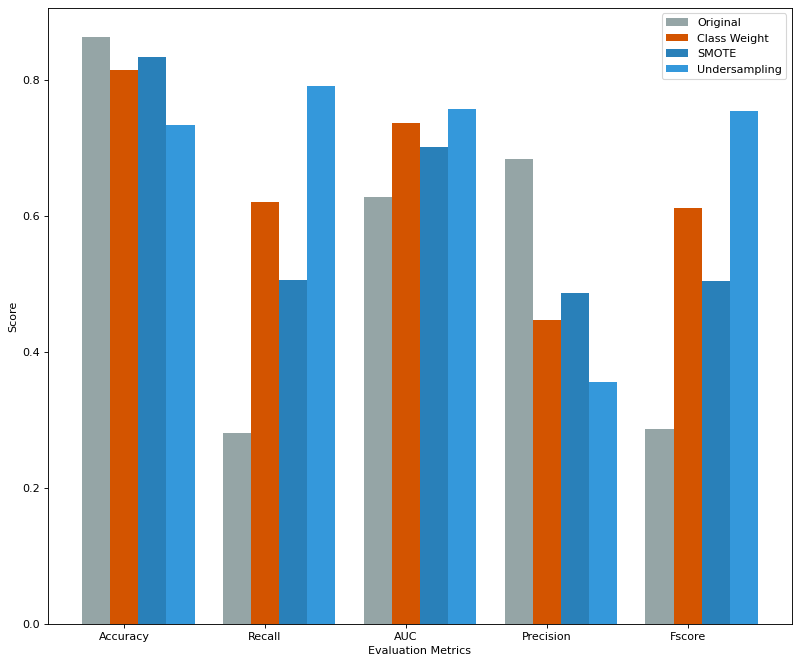

In [ ]:
visualize_eval_metrics(results)

Let's first see what each color means:

* the grey bars represent the original model, 

* the orange bars represent the model with class weight,

* the dark blue bars represent model trained with SMOTE,

* the light blue bars represent the model trained with undersampling.

As we can infer the following insights from the bar charts:

* All models have high accuracy.

* Recall is improved with class weights and resampling methods, and undersampling produces the highest recall.

* AUC is also improved with class weights and resampling methods, and undersampling produces the highest AUC again.

* Precisions are decreased with class weights and resampling methods as they all introduced many false positives (which are expected as we are trying to increase the impact of the positive class).

* Fscore is improved with class weights and resampling method, and undersampling has the highest Fscore.

By analyzing the bar chart above, we can see that undersampling seems to be the best method to help alleviate the imbalanced challenge in the customer churn dataset. Although all class weights, SMOTE, and undersampling decreased the precision (increased false positives) but sometimes it is not a bad idea to assume some of your customers are about to leave (even if they are not) as motivation to improve your services.

$ \ $ 

---

## ***Scenario: Tumor Type Estimation***

$ \ $ 

Finally, let's see an interesting imbalanced dataset that has very high Precision, Recall, and F-score initially without using class reweighting and resampling. This dataset contains tumor samples and we need to estimate/predict if a tumor sample is cancerous or not.

$ \ $ 

$(1)$ Let's load and split the dataset.

In [ ]:
tumor_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_cancer.csv", index_col=False)

In [ ]:
X_train, X_test, y_train, y_test = split_data(tumor_df)

$ \ $

$(2)$ Check its class distribution.

In [ ]:
values = y_train.value_counts()
values

0    355
1    176
Name: Class, dtype: int64

<Axes: >

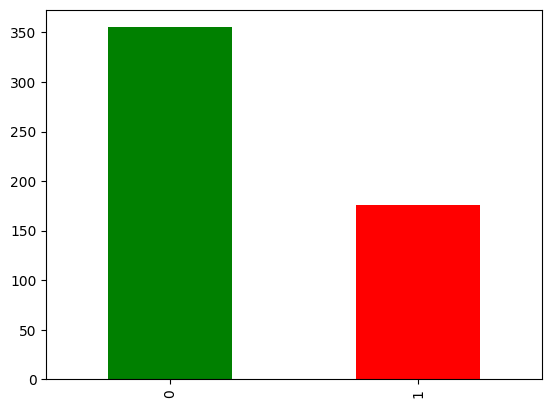

In [ ]:
values.plot.bar(color = ['green', 'red'])

As we can see, this dataset is not as imbalanced as previous datasets. So that it is possible we don't need to use class reweighting and resampling in order to have good classification performance.

$ \ $

$(2)$ We create a synthetic datasets with ***SMOTE***, ***RandomUnderSampler*** to compare their performance.

In [ ]:
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

$ \ $

$(3)$ Use tuned random forest parameters.

In [ ]:
best_params_weight = {'class_weight': {0: 0.2, 1: 0.8}, 
                      'max_depth': 10, 
                      'min_samples_split': 5, 
                      'n_estimators': 50,
                      'bootstrap': True}

$ \ $

$(4)$ Train and evaluate different random forest models on the tumor type dataset.

In [ ]:
# creamos una lista vacia
results = []

In [ ]:
# construimos una funcion la cual devuelve un clasificador de bosques aleatorio entrenado con la data X_train, y_train
y_pred, model = build_rf(X_train, y_train, X_test)

# pegamos las metricas basicas entre la data de prueba y la data predecida y_test, y_pred
results.append(evaluate(y_test, y_pred))

In [ ]:
# construimos una funcion la cual devuelve un clasificador de bosques aleatorio entrenado con la data X_train, y_train y los parametros anteriores
y_pred, model = build_rf(X_train, y_train, X_test, best_params = best_params_weight)

# pegamos las metricas basicas entre la data de prueba y la data predecida y_test, y_pred
results.append(evaluate(y_test, y_pred))


In [ ]:
# construimos una funcion la cual devuelve un clasificador de bosques aleatorio entrenado con la data X_smo, y_smo 
y_pred, model = build_rf(X_smo, y_smo, X_test)

# pegamos las metricas basicas entre la data de prueba y la data predecida y_test, y_pred
results.append(evaluate(y_test, y_pred))

In [ ]:
# construimos una funcion la cual devuelve un clasificador de bosques aleatorio entrenado con la data X_under, y_under 
y_pred, model = build_rf(X_under, y_under, X_test)

# pegamos las metricas basicas entre la data de prueba y la data predecida y_test, y_pred
results.append(evaluate(y_test, y_pred))

In [ ]:
print(results)

[{'type': 'Original', 'accuracy': 0.9849624060150376, 'recall': 1.0, 'auc': 0.9887640449438202, 'precision': 0.9565217391304348, 'fscore': 0.9982547993019196}, {'type': 'Original', 'accuracy': 0.9924812030075187, 'recall': 1.0, 'auc': 0.9943820224719101, 'precision': 0.9777777777777777, 'fscore': 0.9991266375545852}, {'type': 'Original', 'accuracy': 0.9924812030075187, 'recall': 1.0, 'auc': 0.9943820224719101, 'precision': 0.9777777777777777, 'fscore': 0.9991266375545852}, {'type': 'Original', 'accuracy': 0.9849624060150376, 'recall': 1.0, 'auc': 0.9887640449438202, 'precision': 0.9565217391304348, 'fscore': 0.9982547993019196}]


       type  accuracy  recall       auc  precision    fscore
0  Original  0.984962     1.0  0.988764   0.956522  0.998255
1  Original  0.992481     1.0  0.994382   0.977778  0.999127
2  Original  0.992481     1.0  0.994382   0.977778  0.999127
3  Original  0.984962     1.0  0.988764   0.956522  0.998255




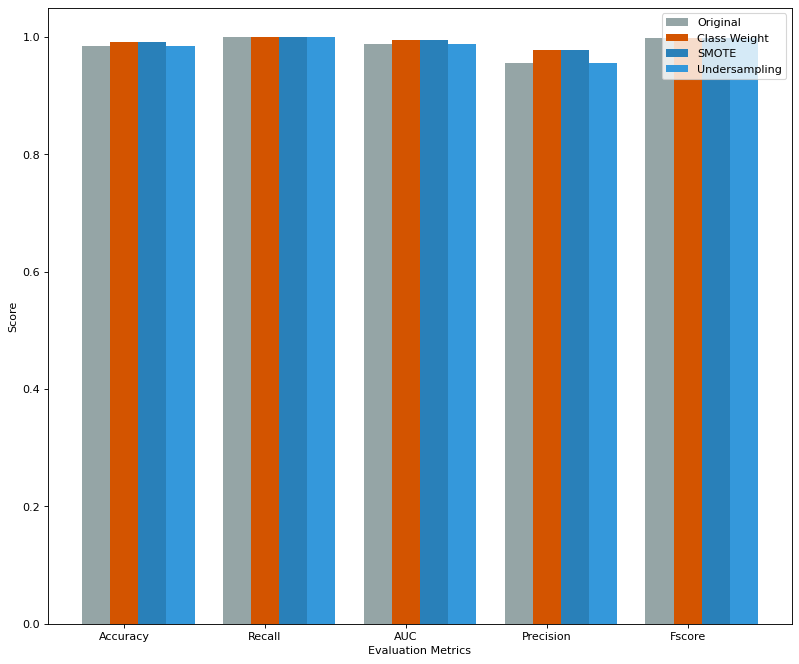

In [ ]:
visualize_eval_metrics(results)

As we can see, all grey bars (the original model) for Accuracy, Recall, AUC, Precision, and F-score have very high values and adding class reweighting and resampling does not help improve performance that much. This is possible that the tumor patterns in this dataset are obvious and can be easily picked up by the standard random forest model or the dataset is not very imbalanced and can be considered as an ordinary binary classification task.

$ \ $

-----

## ***Exercise (predicting Job Change)***

$ \ $

Now it is time to apply what you have learned in this lab. We have an imbalanced HR dataset and we want to use it to build a classification model to predict if an employee is looking for a new job or not.

$ \ $

$(1)$ Load the dataset.

In [ ]:
hr_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_hr.csv", index_col = False)

$ \ $

$(2)$ Let's split the dataset.

In [ ]:
X_train, X_test, y_train, y_test = split_data(hr_df)

$ \ $

$(3)$ Check its class distribution.

In [ ]:
values = y_train.value_counts()
values

0    11504
1     1120
Name: Class, dtype: int64

<Axes: >

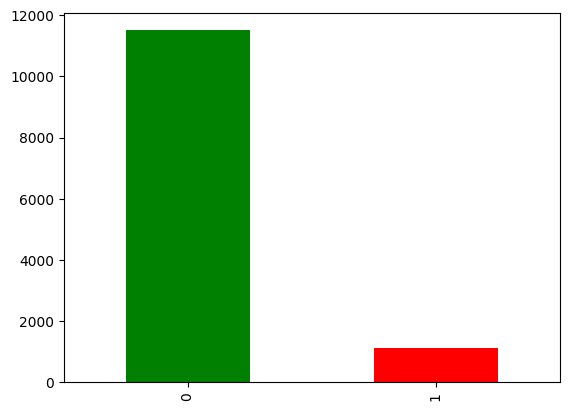

In [ ]:
values.plot.bar(color = ['green', 'red'])

$ \ $

$(4)$ Use tuned random forest parameters.

In [ ]:
best_params = {'class_weight': {0: 0.1, 1: 0.9}}

$ \ $

$(5)$ Build a logistic regression model with the original dataset.

In [ ]:
results = []

In [ ]:
y_pred, model = build_lr(X_train, y_train, X_test)
result = evaluate(y_test, y_pred)
results.append(result)

$ \ $

$(6)$ Add class weights to the model.

In [ ]:
y_pred, weight_model = build_lr(X_train, y_train, X_test, best_params = best_params)
result = evaluate(y_test, y_pred, eval_type = "Class Weight")
results.append(result)

$ \ $

$(7)$ Improve the model with SMOTE resampled dataset.

In [ ]:
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)
y_pred, smote_model = build_lr(X_smo, y_smo, X_test)
result = evaluate(y_test, y_pred, eval_type = "SMOTE")
results.append(result)

$ \ $ 

$(8)$ Improve the model with Undersampling resampled dataset.

In [ ]:
y_pred, under_model = build_lr(X_under, y_under, X_test)
result = evaluate(y_test, y_pred, eval_type = "Undersampling")
results.append(result)

$ \ $

$(9)$ Let's look a visualization of our results.

            type  accuracy    recall       auc  precision    fscore
0       Original  0.911625  0.003571  0.501786   1.000000  0.003714
1   Class Weight  0.751663  0.582143  0.675152   0.196386  0.541252
2          SMOTE  0.715869  0.610714  0.668409   0.178311  0.558613
3  Undersampling  0.712385  0.614286  0.668109   0.176955  0.560963




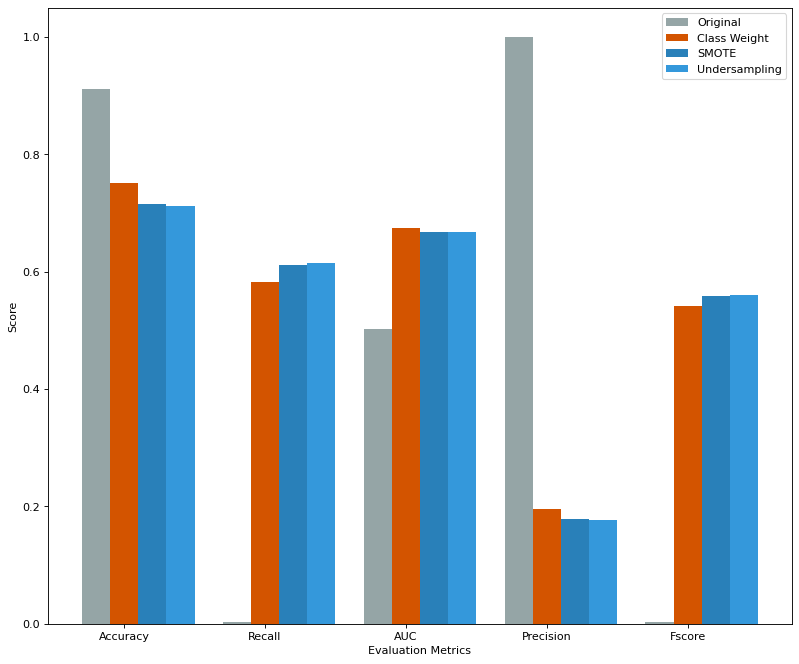

In [ ]:
visualize_eval_metrics(results)